In [1]:
# !pip install tensorflow_datasets==4.3

     |████████████████████████████████| 3.9 MB 2.6 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from cv2 import cv2
from skimage import feature

In [4]:
# constants
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
IMG_SIZE = 256

In [5]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'deep_weeds',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


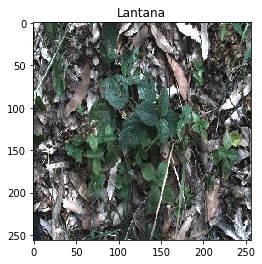

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [6]:
# helpers
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

NameError: name 'image' is not defined

In [7]:
(train_datasets, validation_datasets, test_datasets), metadata = tfds.load(
    'deep_weeds',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [8]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

# image to grayscale augmentation
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  return image, label

In [9]:
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))
val_ds = tf.data.Dataset.zip((validation_datasets, (counter, counter)))
test_ds = tf.data.Dataset.zip((test_datasets, (counter, counter)))

Instructions for updating:
Use `tf.data.Dataset.scan(...) instead


Instructions for updating:
Use `tf.data.Dataset.scan(...) instead


In [10]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(augment, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [11]:
test_ds = (
    test_ds
    .map(augment, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [12]:
train_ds_numpy = [(example.numpy(), label.numpy()) for example, label in train_ds if label < 8]
# y_train = filter_negatives([label.numpy() for example, label in train_ds])

test_ds_numpy = [(example.numpy(), label.numpy()) for example, label in test_ds if label < 8]
# y_test = filter_negatives([label.numpy() for example, label in test_ds])


In [13]:
x_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

x_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

In [14]:
print(np.array(x_train).shape)

(6672, 256, 256, 3)


In [15]:
sigma = 1.5
x_train_canny = list(map(lambda x: feature.canny(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), sigma=sigma), x_train))
x_test_canny = list(map(lambda x: feature.canny(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), sigma=sigma), x_test))

Text(0.5, 1.0, 'from X_test with $\\sigma=1.5$')

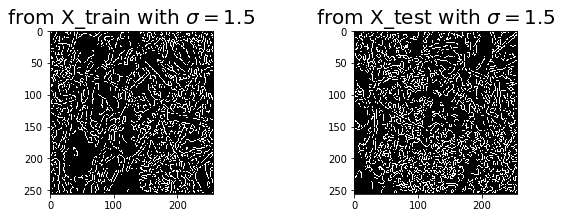

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

ax[0].imshow(x_train_canny[0], cmap='gray')
ax[0].set_title(r'from X_train with $\sigma=1.5$', fontsize=20)

ax[1].imshow(x_test_canny[0], cmap='gray')
ax[1].set_title(r'from X_test with $\sigma=1.5$', fontsize=20)

In [17]:
x_train_canny_flattened = list(map(lambda x: x.flatten(), x_train_canny))
x_test_canny_flattened = list(map(lambda x: x.flatten(), x_test_canny))

In [18]:
print(len(x_train_canny_flattened))
print(x_train_canny_flattened[0])

6672
[False False False ... False False False]


In [19]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier()
knn.fit(x_train_canny_flattened, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [20]:
print(x_train_canny_flattened[0])
print(y_train[0])

[False False False ... False False False]
5


In [21]:
print(knn.predict([x_test_canny_flattened[0]]))
print(y_test[0])

[3]
6


In [22]:
print(knn.score(x_test_canny_flattened, y_test))

0.12746234067207415
